<a href="https://colab.research.google.com/github/Lukaid/my_notebook/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 마이닝을 위한 전처리 
## KoNLP를 이용한 형태소 분석 
- KoNLPy가 제공하는 형태소분석기 중 하나인 Kkma를 사용합니다.
- 자세한 내용은 http://konlpy.org/ko/v0.4.3/morph/ 참조

In [1]:
# KoNLPy 라이브러리 설치. 최초 1회만 실행
!set - x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

     |████████████████████████████████| 19.4MB 40.9MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 460kB 55.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/etc/os-release:PRE

In [2]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 데이터 탐색 및 전처리

In [3]:
# 데이터를 불러옵니다. review.sorted.uniq.refined.tok.tsv
from google.colab import files
uploaded = files.upload()

Saving review.sorted.uniq.refined.tok.tsv to review.sorted.uniq.refined.tok.tsv


In [4]:
names = ['label', 'review']

In [5]:
pre_review = pd.read_table('review.sorted.uniq.refined.tok.tsv', encoding = 'utf - 8', header = None, names=names)

In [6]:
pre_review.head()

,label,review
0,negative,!
1,negative,! 다 녹 아서 왓 어요 . . 짜증
2,negative,!!!!!!!!!!!!!
3,negative,!!!! 이게 뭐 야 ? 진짜 이게 뭐 야 ? 리뷰 보고 구매 했 는데 ! 나원참 !
4,negative,싼 게 비지떡 . 200 ml 라고 판매 하 는데 내 가 보 기 엔 절대 이거 1...


In [7]:
pre_review_only_review = pre_review['review']
pre_review_only_review.head()

0                                                   ! 
1                                ! 다 녹 아서 왓 어요 . . 짜증 
2                                       !!!!!!!!!!!!! 
3     !!!! 이게 뭐 야 ? 진짜 이게 뭐 야 ? 리뷰 보고 구매 했 는데 ! 나원참 ! 
4     싼 게 비지떡 . 200 ml 라고 판매 하 는데 내 가 보 기 엔 절대 이거 1...
Name: review, dtype: object

In [8]:
# 형태소분석 - kkma 명사 
mecab = Mecab()

line_list = []

for line in pre_review_only_review:
    line = mecab.nouns(line)
    line_list.append(line)

print("- 불러온 문서 :", len(line_list), "문장")

- 불러온 문서 : 302678 문장


In [9]:
line_list[0:4]

[[], ['짜증'], [], ['이게', '이게', '리뷰', '구매']]

In [10]:
# 데이터를 불러옵니다. stop_words_korean.txt
from google.colab import files
uploaded = files.upload()

Saving stop_words_korean.txt to stop_words_korean.txt


In [11]:
stop_list = []

f = open("stop_words_korean.txt", encoding="utf-8")
for line in f:
    stop_list.append(line[:-1])
f.close()

print("- 불러온 문서 :", len(stop_list), "문장")

- 불러온 문서 : 676 문장


In [12]:
stop_list = stop_list[0:-1]

In [13]:
word_frequency = {}
noun_list = []
# stop_list는 위에서 정의
line_number = 0
for line in line_list[:]:
    line_number += 1
    print(str(line_number) + "/" + str(len(line_list)), end="\r")
    noun = []
    for word in line:
        if word.split("/")[0] not in stop_list and len(word.split("/")[0]) > 1:  
            noun.append(word.split("/")[0])
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
    noun_list.extend(noun)

In [14]:
#단어별 출현빈도를 출력합니다.
word_count = []
for n, freq in word_frequency.items():
    word_count.append([n, freq])
word_count.sort(key=lambda elem: elem[1], reverse=True)
for n, freq in word_count[:10]:
    print(n + "\t" + str(freq))

배송	65947
구매	43823
가격	34401
제품	31465
사용	24374
만족	23695
상품	19895
주문	19565
생각	16023
감사	15753


### LDA 토픽 모델링

In [17]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# stop_list = []

texts = []
for line in line_list:
    words = line
    if words != [""]:
        tokens = [word for word in words if (len(word.split("/")[0]) > 1 and word.split("/")[0] not in stop_list)]
        texts.append(tokens)
dictionary = corpora.Dictionary(texts)    
corpus = [dictionary.doc2bow(text) for text in texts]


In [19]:
min_topics, max_topics = 10, 25
coherence_scores = []

for num_topic in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics = num_topic, id2word = dictionary)
    coherence = CoherenceModel(model = model,
                               texts = texts,
                               dictionary = dictionary)
    coherence_scores.append(coherence.get_coherence())
    print(f'num_topic = {num_topic} 완료')

print(coherence_scores)

num_topic = 10 완료
num_topic = 11 완료
num_topic = 12 완료
num_topic = 13 완료
num_topic = 14 완료
num_topic = 15 완료
num_topic = 16 완료
num_topic = 17 완료
num_topic = 18 완료
num_topic = 19 완료
num_topic = 20 완료
num_topic = 21 완료
num_topic = 22 완료
num_topic = 23 완료
num_topic = 24 완료
[0.3851671973622369, 0.3983917522795462, 0.39828286946804536, 0.41221673405046094, 0.38156810093783994, 0.3999652290059019, 0.39036916394456933, 0.4067625458283892, 0.3822300173966799, 0.38829493498516926, 0.37111887899226487, 0.3781166026856421, 0.3660016400894779, 0.3895258795569067, 0.37499439559089387]


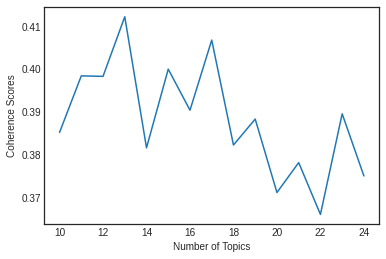

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

x = [int(i) for i in range(min_topics, max_topics)]

plt.figure()
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

In [21]:
LDAmodel = LdaModel(corpus, num_topics = 22, id2word = dictionary)
topics = LDAmodel.print_topics(num_topics = 22)
topics

[(0,
  '0.071*"기저귀" + 0.036*"용량" + 0.033*"이유식" + 0.031*"보통" + 0.028*"세트" + 0.024*"특가" + 0.024*"시작" + 0.024*"허리" + 0.023*"아기" + 0.022*"밴드"'),
 (1,
  '0.063*"이거" + 0.063*"마니" + 0.050*"화면" + 0.027*"부분" + 0.027*"필름" + 0.025*"터치" + 0.023*"유리" + 0.021*"액정" + 0.021*"보호" + 0.020*"극추"'),
 (2,
  '0.085*"이랑" + 0.075*"사진" + 0.044*"아들" + 0.031*"블랙" + 0.026*"비교" + 0.025*"예전" + 0.023*"차이" + 0.023*"흡수" + 0.021*"모양" + 0.020*"두께"'),
 (3,
  '0.381*"제품" + 0.099*"배송" + 0.097*"적극" + 0.039*"완전" + 0.027*"신랑" + 0.024*"빠름" + 0.017*"보습" + 0.011*"후회" + 0.011*"용기" + 0.010*"클렌징"'),
 (4,
  '0.153*"아요" + 0.059*"수고" + 0.051*"케이스" + 0.034*"우산" + 0.028*"편리" + 0.023*"소리" + 0.017*"화이트" + 0.017*"정품" + 0.014*"강아지" + 0.013*"스틱"'),
 (5,
  '0.278*"감사" + 0.162*"조아" + 0.084*"추천" + 0.079*"마음" + 0.075*"최고" + 0.054*"번창" + 0.049*"요조" + 0.019*"하루" + 0.016*"가성" + 0.010*"고민"'),
 (6,
  '0.057*"유통" + 0.055*"기한" + 0.048*"양말" + 0.041*"사료" + 0.034*"모기" + 0.029*"간식" + 0.020*"기간" + 0.020*"제조" + 0.017*"건전지" + 0.016*"뚜껑"'),
 (7,
  '0.050*"색깔" +

### 토픽 모델링 시각화

In [26]:
!pip install pyldavis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package pyLDAvis
     |████████████████████████████████| 1.7MB 6.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 17.2MB/s 
     |████████████████████████████████| 15.3MB 218kB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=86af876d91e15a2c07096c9c140fc794e235df3784901e0ea2f0f36bcfea58aa
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyldavis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
import numpy as np

pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(LDAmodel, corpus, dictionary)
prepared_data = gensimvis.prepare(LDAmodel, corpus, dictionary)
gamma, _ = topic_model.inference(corpus)
pyLDAvis.display(prepared_data)
pyLDAvis.save_html(prepared_data, pyldavis_html_path)

ImportError: ignored

In [38]:
!apt install pyLDAvis.gensim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package pyLDAvis.gensim
E: Couldn't find any package by glob 'pyLDAvis.gensim'
E: Couldn't find any package by regex 'pyLDAvis.gensim'


In [39]:
import pyLDAvis
import pyLDAvis.gensim

model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDAmodel)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

ModuleNotFoundError: ignored

In [ ]:
mecab = Mecab()
tokenized_data = []
for sentence in result[0]:
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec의 하이퍼파라미터값
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [ ]:
from gensim.models import Word2Vec
from gensim.models import FastText

model_w = Word2Vec(sentences=line_list, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
model_f = FastText(sentences=line_list, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
model_w_result = model_w.wv.most_similar("반품")
print(model_w_result)
model_f_result = model_f.wv.most_similar("반품")
print(model_f_result)